# DRILLING IA TRAINING

 Data loaded.
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Model saved successfully.

        VALUE REPORT: ARTIFICIAL INTELLIGENCE        
 Critical Event Date (Stuck Pipe):  2023-04-18 18:10:00
 Early Detection Date (AI):         2023-04-11 14:05:00
------------------------------------------------------------
 REACTION TIME GAINED:            172.1 HOURS (7.2 Days)
------------------------------------------------------------
 POTENTIAL ECONOMIC IMPACT:
   (Base: NPT Cost = $5,000 / hour)
   VALUE PRESERVED:                 $860,416.67 USD


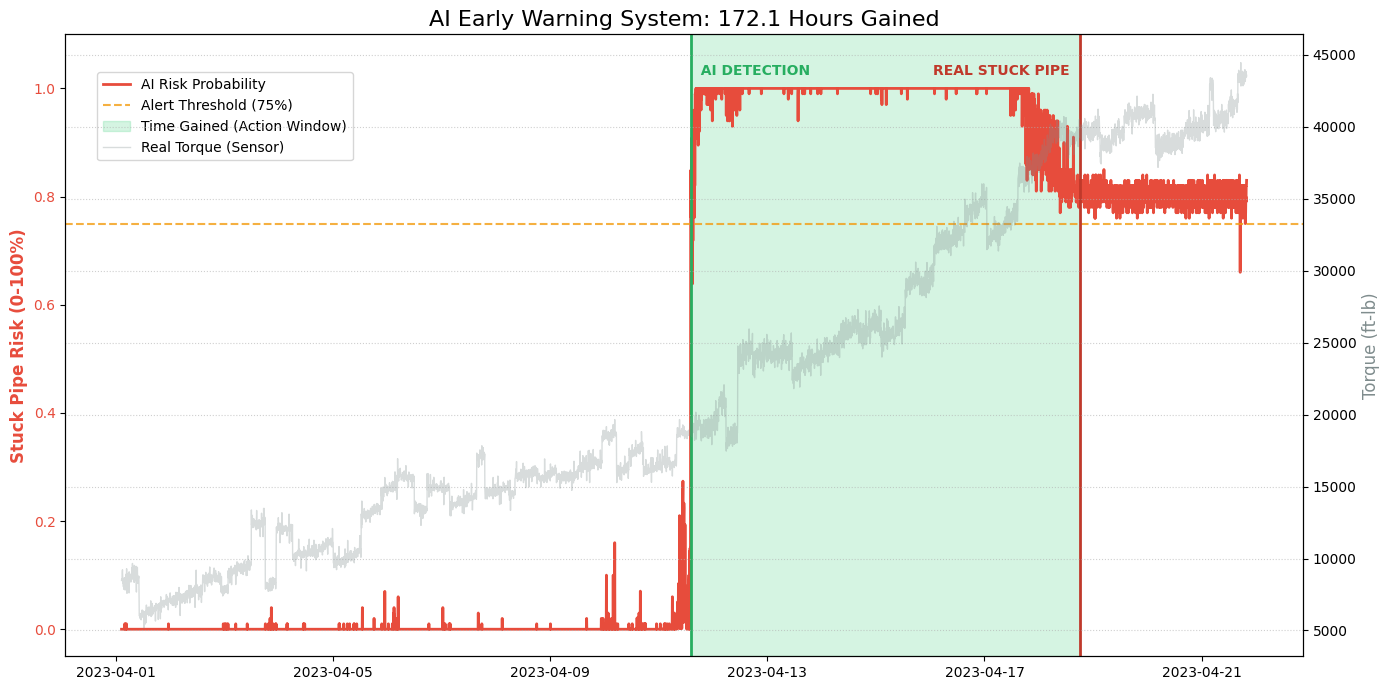

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

# 1. LOAD DATA 
try:
    df = pd.read_csv('drilling_data_stuckpipe.csv') # Ajusta ruta si es necesario '../Data/...'
    df['Date'] = pd.to_datetime(df['Date'])
    print(" Data loaded.")
except FileNotFoundError:
    print(" Error: File not found.")
    exit()

# 2. FEATURE ENGINEERING 
def feature_engineering(df):
    window = 30 
    df['Torque_Trend'] = df['Torque_ft_lb'] / df['Torque_ft_lb'].rolling(window=window).mean()
    df['ROP_Trend'] = df['ROP_m_hr'] / df['ROP_m_hr'].rolling(window=window).mean()
    df['SPP_Trend'] = df['SPP_PSI'] / df['SPP_PSI'].rolling(window=window).mean()
    df['Friction_Factor'] = df['Torque_ft_lb'] / (df['WOB_klbs'] * df['Depth_m'] + 1)
    return df.dropna().copy()

df_model = feature_engineering(df)

# 3. MODEL TRAINING (GRID SEARCH) 
features = ['ROP_m_hr', 'Torque_ft_lb', 'WOB_klbs', 'RPM', 'SPP_PSI', 'MSE_PSI', 
            'Torque_Trend', 'ROP_Trend', 'SPP_Trend', 'Friction_Factor']

target = df_model['Phase_Status'].apply(lambda x: 1 if x in ['Alerta', 'Critica', 'Stuck'] else 0)

# Div Train/Test 
X = df_model[features]
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Conf GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

model = RandomForestClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=3) 

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

joblib.dump(best_model, 'stuckpipe_brain.joblib')
print(" Model saved successfully.")

# Saving
configuracion = {
    'umbral_corte': 0.75,
    'columnas_entrenamiento': features
}
joblib.dump(configuracion, 'Conf_IA.joblib')

# 4. APPLY MODEL & PREDICT 

probs_totales = best_model.predict_proba(df_model[features])[:, 1]
df_model['Risk_Probability'] = probs_totales 

# 5. ECONOMIC IMPACT REPORT 
def generate_impact_report(df_results, alert_threshold=0.75):
    stuck_events = df_results[df_results['Phase_Status'] == 'Stuck']
    if len(stuck_events) == 0:
        print(" No Stuck Pipe events detected.")
        return None, None

    real_stuck_date = stuck_events['Date'].iloc[0]
    
    ai_alerts = df_results[
        (df_results['Risk_Probability'] >= alert_threshold) & 
        (df_results['Date'] < real_stuck_date)
    ]
    
    print("\n" + "="*60)
    print("        VALUE REPORT: ARTIFICIAL INTELLIGENCE        ")
    print("="*60)
    
    if len(ai_alerts) > 0:
        ai_alert_date = ai_alerts['Date'].iloc[0]
        time_gained = real_stuck_date - ai_alert_date
        hours_gained = time_gained.total_seconds() / 3600
        days_gained = hours_gained / 24
        estimated_savings = hours_gained * 5000 

        print(f" Critical Event Date (Stuck Pipe):  {real_stuck_date}")
        print(f" Early Detection Date (AI):         {ai_alert_date}")
        print("-" * 60)
        print(f" REACTION TIME GAINED:            {hours_gained:.1f} HOURS ({days_gained:.1f} Days)")
        print("-" * 60)
        print(f" POTENTIAL ECONOMIC IMPACT:")
        print(f"   (Base: NPT Cost = $5,000 / hour)")
        print(f"   VALUE PRESERVED:                 ${estimated_savings:,.2f} USD")
        print("="*60)
        return ai_alert_date, real_stuck_date
    else:
        print(" AI did not generate early warning.")
        return None, real_stuck_date

# Run report and get dates for plotting
ai_date, real_date = generate_impact_report(df_model)

# 6. VISUALIZATION 
if ai_date and real_date:
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot 1: AI Risk Probability (Left Axis - Red)
    ax1.plot(df_model['Date'], df_model['Risk_Probability'], color='#e74c3c', label='AI Risk Probability', linewidth=2)
    ax1.set_ylabel('Stuck Pipe Risk (0-100%)', color='#e74c3c', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='#e74c3c')
    ax1.set_ylim(-0.05, 1.1)
    
    # Threshold Line
    ax1.axhline(y=0.75, color='#f39c12', linestyle='--', alpha=0.8, label='Alert Threshold (75%)')

    # Plot 2: Physical Torque (Right Axis - Gray)
    ax2 = ax1.twinx()
    ax2.plot(df_model['Date'], df_model['Torque_ft_lb'], color='#7f8c8d', alpha=0.3, label='Real Torque (Sensor)', linewidth=1)
    ax2.set_ylabel('Torque (ft-lb)', color='#7f8c8d', fontsize=12)
    
    # Highlight: Time Gained Zone (Green Area)
    ax1.axvspan(ai_date, real_date, color='#2ecc71', alpha=0.2, label='Time Gained (Action Window)')
    
    # Annotations
    ax1.axvline(x=ai_date, color='#27ae60', linestyle='-', linewidth=2)
    ax1.text(ai_date, 1.02, '  AI DETECTION', color='#27ae60', fontweight='bold', ha='left', va='bottom')
    
    ax1.axvline(x=real_date, color='#c0392b', linestyle='-', linewidth=2)
    ax1.text(real_date, 1.02, 'REAL STUCK PIPE  ', color='#c0392b', fontweight='bold', ha='right', va='bottom')

    # Final Polish
    plt.title(f'AI Early Warning System: {(real_date - ai_date).total_seconds()/3600:.1f} Hours Gained', fontsize=16)
    plt.grid(True, linestyle=':', alpha=0.6)
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.02, 0.95))
    
    plt.tight_layout()
    plt.show()